In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [36]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [37]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

gtex_cerb_gtf = od+expand(config['gtex']['cerberus']['gtf'], species='human')[0]
gtex_filt_ab = od+expand(config['gtex']['cerberus']['ab'], species='human')[0]

## Compare how many intron chains are detected in GTEx (all) and in ENCODE (using 1 TPM filter)

In [8]:
ca = cerberus.read(cerberus_h5)

In [32]:
# limit to same samples from the gtex paper?
def get_gtex_match_samples():
    samples = ['adipose',
               'brain',
               'brain_ad',
               'hmec',
               'mcf10a',
               'mcf7',
               'heart',
               'liver',
               'lung',
               'muscle',
               'h9_panc_beta',
               'h9_panc_progen',
               'panc1', 
               'k562']
    return samples

In [48]:
samples = get_gtex_match_samples()
tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df, ids = get_tpm_table(tl_df, 
#                          how='ic',
#                          min_tpm=min_tpm,
#                          gene_subset=None,
#                          sample=samples)
tl_df, ids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=gene_subset,
                         sample=samples)
print(len(tl_df.index))
tl_df = tl_df.loc[tl_df.sum(axis=1)>0]
print(len(tl_df.index))

Calculating ic TPM values
Subsetting for ['adipose', 'brain', 'brain_ad', 'hmec', 'mcf10a', 'mcf7', 'heart', 'liver', 'lung', 'muscle', 'h9_panc_beta', 'h9_panc_progen', 'panc1', 'k562'] samples
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Applying gene type and novelty subset
Number of ics reported: 140810
140810
122665


In [49]:
# get the gtex ICs
df = ca.ic.loc[ca.ic.source.str.contains('gtex')].copy(deep=True)
df['gtex'] = True

df2 = ca.ic.loc[ca.ic.Name.isin(ids)].copy(deep=True)
df2['tl'] = True

merge_cols = ['Chromosome', 'Strand', 'Coordinates', 'source', 'novelty', 'gene_id', 'ic', 'Name']
df = df.merge(df2, how='outer', on=merge_cols)
df.gtex.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)

In [50]:
# get only ics that are spliced
df = df.loc[df.Coordinates != '-']

In [51]:
df[['Name', 'tl', 'gtex']].groupby(['tl', 'gtex']).count().reset_index()

,tl,gtex,Name
0,False,True,57516
1,True,False,101437
2,True,True,30246


In [31]:
df.loc[(df.tl==False)&(df.gtex==True)&(df.ic==1)].head()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic,gtex,tl
61,chr1,+,11068713-11070658,ENSG00000226849_1,"v40,v29,lapa,gtex",Known,ENSG00000226849,1,True,False
97,chr1,+,11610113-11611842-11611978-11612789,ENSG00000235643_1,"v40,v29,lapa,gtex",Known,ENSG00000235643,1,True,False
136,chr1,+,13315658-13318391-13318700-13319371-13319953-1...,ENSG00000204501_1,"v40,v29,gtex",Known,ENSG00000204501,1,True,False
138,chr1,+,143874823-143875218-143875239-143876051-143876...,ENSG00000265531_1,"v40,v29,gtex",Known,ENSG00000265531,1,True,False
166,chr1,+,149782774-149783169-149783190-149784002-149784...,ENSG00000150337_1,"v40,v29,gtex",Known,ENSG00000150337,1,True,False


## Try on just K562

In [81]:
def get_gtex_df_tpm(df, feat, dataset_cols):    
    # dataset_cols = ['wtc11_1_3', 'wtc11_1_2', 'wtc11_1_1']
    df = df[dataset_cols+['annot_transcript_id']]
    if feat != 'triplet':
        df = add_feat(df, col='annot_transcript_id', kind=feat)
        df.drop('annot_transcript_id', inplace=True, axis=1)
        gb_col = feat
    else:
        gb_col = 'annot_transcript_id'
    df = df.groupby(gb_col).sum().reset_index()
    
    return df


In [89]:
min_tpm = 0
gtex_df = pd.read_csv(gtex_filt_ab, sep='\t')
dataset_cols = [c for c in gtex_df.columns if 'K562' in c]
print(dataset_cols)
gtex_df = get_gtex_df_tpm(gtex_df, 'ic', dataset_cols=dataset_cols)
gtex_df.set_index('ic', inplace=True)
gtex_df = gtex_df.loc[gtex_df.sum(axis=1)>0]

tl_df = pd.read_csv(filt_ab, sep='\t')
# tl_df = pd.read_csv(unfilt_ab, sep='\t')
tl_df, tids = get_tpm_table(tl_df, 
                         how='ic',
                         min_tpm=min_tpm,
                         gene_subset=None,
                         sample=['k562'])
tl_df = tl_df.loc[tl_df.sum(axis=1)>0]

# take mean of each library in dataset
tl_df['mean_tpm'] = tl_df.mean(axis=1)
tl_df.reset_index(inplace=True)
tl_df['tl'] = True

gtex_df['gtex_mean_tpm'] = gtex_df.mean(axis=1)
gtex_df['gtex'] = True
gtex_df.reset_index(inplace=True)

df = gtex_df.merge(tl_df, how='outer',
                 on='ic', suffixes=('_gtex', ''))
df.gtex.fillna(False, inplace=True)
df.tl.fillna(False, inplace=True)
df.fillna(0, inplace=True)

df['det_cat'] = df['tl'].astype(str)+'_'+df['gtex'].astype(str)

df['tl_log2_avg_tpm'] = np.log2(df.mean_tpm+1)
df['gtex_log2_avg_tpm'] = np.log2(df.gtex_mean_tpm+1)


df[['gtex', 'tl']].reset_index().groupby(['gtex', 'tl']).count().reset_index()

['K562_ampure_70ng', 'K562_ampure', 'K562_extrawashwarm', 'K562_extrawash']
Calculating ic TPM values
Subsetting for ['k562'] samples
Number of ics reported: 145392


,gtex,tl,index
0,False,True,50596
1,True,False,29486
2,True,True,13854


In [91]:
df.head()

,ic,K562_ampure_70ng,K562_ampure,K562_extrawashwarm,K562_extrawash,gtex_mean_tpm,gtex,k562_1_1,k562_2_1,k562_2_2,k562_3_1,k562_3_2,mean_tpm,tl,det_cat,tl_log2_avg_tpm,gtex_log2_avg_tpm
0,ENSG00000000419_1,61.374036,39.601006,47.128237,54.957505,50.765196,True,22.228461,36.317414,41.470641,29.080918,17.156277,29.250742,True,True_True,4.918899,5.693911
1,ENSG00000000419_14,0.713652,1.841907,0.000000,1.691000,1.061640,True,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False_True,0.000000,1.043792
2,ENSG00000000419_16,2.140955,0.920954,0.000000,2.536500,1.399602,True,0.823276,0.000000,2.303925,1.384806,0.000000,0.902401,True,True_True,0.927822,1.262795
3,ENSG00000000419_2,0.713652,0.920954,0.826811,0.845500,0.826729,True,0.823276,2.075281,0.000000,1.384806,1.270835,1.110840,True,True_True,1.077817,0.869263
4,ENSG00000000419_20,4.995561,6.446675,5.787678,5.073000,5.575729,True,0.000000,3.112921,2.303925,0.692403,0.000000,1.221850,True,True_True,1.151761,2.717151


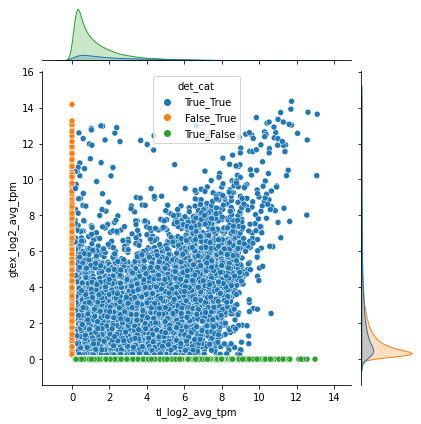

In [92]:
sns.jointplot(df, y='gtex_log2_avg_tpm', x='tl_log2_avg_tpm', hue='det_cat')

In [95]:
df.loc[(df.det_cat=='True_False')&(df.tl_log2_avg_tpm>10)]

,ic,K562_ampure_70ng,K562_ampure,K562_extrawashwarm,K562_extrawash,gtex_mean_tpm,gtex,k562_1_1,k562_2_1,k562_2_2,k562_3_1,k562_3_2,mean_tpm,tl,det_cat,tl_log2_avg_tpm,gtex_log2_avg_tpm
48401,ENSG00000083845_1,0.0,0.0,0.0,0.0,0.0,False,838.095301,3605.800410,2568.875823,589.234798,807.615862,1681.924439,True,True_False,10.716755,0.0
48731,ENSG00000087086_1,0.0,0.0,0.0,0.0,0.0,False,4770.886315,14686.762303,13189.967791,3483.478576,4175.329528,8061.284902,True,True_False,12.976973,0.0
49115,ENSG00000089157_7,0.0,0.0,0.0,0.0,0.0,False,2968.734435,0.000000,0.000000,3533.331579,4479.694593,2196.352121,True,True_False,11.101550,0.0
49888,ENSG00000096384_1,0.0,0.0,0.0,0.0,0.0,False,7639.181038,4220.083530,2488.238465,7794.378520,7828.981146,5994.172540,True,True_False,12.549586,0.0
54566,ENSG00000108561_1,0.0,0.0,0.0,0.0,0.0,False,754.944392,1291.862305,1154.266177,1160.467123,1089.741309,1090.256261,True,True_False,10.091774,0.0
55492,ENSG00000110955_1,0.0,0.0,0.0,0.0,0.0,False,981.345382,2664.660562,2165.689035,817.035325,831.126316,1491.971324,True,True_False,10.543971,0.0
55875,ENSG00000111716_1,0.0,0.0,0.0,0.0,0.0,False,981.345382,2317.051026,2214.071449,844.039035,995.699493,1470.441277,True,True_False,10.523014,0.0
56383,ENSG00000113013_1,0.0,0.0,0.0,0.0,0.0,False,1830.143275,437.884251,612.843918,1312.795743,1136.126799,1065.958797,True,True_False,10.059289,0.0
57739,ENSG00000116560_1,0.0,0.0,0.0,0.0,0.0,False,1497.539639,41.505616,216.568903,2597.202970,1868.763376,1244.316101,True,True_False,10.282296,0.0
60201,ENSG00000124614_1,0.0,0.0,0.0,0.0,0.0,False,689.082286,3194.894809,2352.306920,555.999463,738.355336,1506.127763,True,True_False,10.557586,0.0


In [96]:
df.loc[(df.det_cat=='False_True')&(df.gtex_log2_avg_tpm>10)]

,ic,K562_ampure_70ng,K562_ampure,K562_extrawashwarm,K562_extrawash,gtex_mean_tpm,gtex,k562_1_1,k562_2_1,k562_2_2,k562_3_1,k562_3_2,mean_tpm,tl,det_cat,tl_log2_avg_tpm,gtex_log2_avg_tpm
3391,ENSG00000071082_18,7260.691214,8335.551297,8101.095856,8044.087756,7935.356531,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,12.954261
3392,ENSG00000071082_19,1363.074525,1804.148159,1621.376707,1490.616640,1569.804008,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,10.617287
15414,ENSG00000122406_23,1064.054512,1472.604853,1379.121034,1614.059652,1382.460013,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,10.434065
15415,ENSG00000122406_24,1807.679462,1584.040242,1528.773856,1410.294133,1582.696923,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,10.629081
16544,ENSG00000125835_18,408.208706,3526.331446,7988.649536,9839.084425,5440.568528,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,12.409807
19375,ENSG00000134333_30,1363.788177,1181.583506,1117.848703,1102.532104,1191.438122,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,10.219699
19578,ENSG00000134825_16,1183.234326,1394.323794,1494.874598,1418.749133,1372.795463,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,10.423952
19838,ENSG00000135390_15,1235.330892,1486.419157,1339.434097,1407.757632,1367.235445,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,10.418101
19903,ENSG00000135486_114,2233.015806,2194.632498,2041.396782,2021.590690,2122.658944,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,11.052336
20132,ENSG00000135940_10,1722.041272,1675.214651,1735.476648,1671.553657,1701.071557,True,0.0,0.0,0.0,0.0,0.0,0.0,False,False_True,0.0,10.733076


In [ ]:
# how often are the ones called in GTEx but not in ENCODE monoexonic? How often are they the IC from the mane isoform?